## Project - Semi-Supervised Learning (Pseudo-Labeling)

##### Name: JAECHAN PARK
##### Student Number : K11850713
##### Contact E-mail : k11850713@students.jku.at  or  figo721@hotmail.com
##### Supervisor : Dr. Andreu Vall

### Outline

    +-- < Section 1 : Data preprocessing & Define a forward neural network model and functions >
    |   +-- Section 1-1 : Data preprocessing
    |   +-- Section 1-2 : Define a forward neural network and functions 
    |   |
    +-- < Section 2 : Train the FNN model and assigned pseudo-labeling >
    |   +-- Section 2-1 : Train the FNN model
    |   +-- Section 2-2 : Assigned pseudo-labels
    |   |
    +-- < Section 3 : Train the FNN Model with a combined dataset and predicted binary labels >
    |   +-- Section 3-1 : Train the FNN model with a combined dataset
    |   +-- Section 3-2 : Assigned new pseudo-labels to "train_B_tensor"
    
    

## Import libraries 

In [1]:
import numpy as np
import pandas as pd
import rdkit
import torch
import pickle
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.feature_selection import VarianceThreshold
import torch.nn as nn
from torch import optim
from sklearn import metrics
from sklearn.utils import shuffle

## Section 1 : Data preprocessing & Define a forward neural network model and functions

### Section 1-1 : Data preprocessing

In [2]:
# To enable GPU device 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.cuda.is_available()


# The defined function is to convert a dataset into the torch.tensor format for passing through the neural network.

def torch_tensor(data):
    """
    implementation of converting to PyTorch tensor to be passed through a defined neural network created by a PyTorch library
    Arguments:
    data -- list, list to be converted into a PyTorch tensor format to pass through a neural network model
    
    Returns:
    temp_tensor -- pytorch.tensor, a converted arrays with pytorch.tensor format
    """
    temp = np.array(data)
    temp = temp.astype(np.float32)
    temp_tensor = torch.from_numpy(temp)
    
    return temp_tensor

#############################################################################################

# load the provided dataset

with open('clintox_as_dict.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert the format of the molecular descriptor fingerprint to pandas DataFrame
X_pd = pd.DataFrame(data['X'])
y_pd = pd.DataFrame(data['y'])

# Concatenate the descriptor fingerprint and corresponding labels ('CT_TOX') 
combined_data = pd.concat([X_pd,y_pd[0]], axis=1)

# Rename the last column to "CT_TOX"
combined_data.columns = [*combined_data.columns[:-1], 'CT_TOX']
combined_data['CT_TOX'].value_counts()

# According to the bar chart, there are 6 abnormal value of labels from the dataset.
# To prevent noise from input source, the labels have to be removed.
combined_data_cleaned = combined_data.drop(combined_data.loc[combined_data['CT_TOX'] == 1000000.0 ].index)

# make another bar plot after excluded the six labels
# combined_data_cleaned['CT_TOX'].value_counts().plot(kind='bar')
train_index = data['train_idx']

# make a list of train index to make a subset from the dataset.
train_idx_list = list(train_index)

## Make a subset from the dataset(combined_data_cleaned) along the list of train_index
train_data = pd.DataFrame(combined_data_cleaned, train_idx_list)

########################################################################################################################

"""
The following is to split the whole training dataset into a set of training and a set of validation set

X_train -- list, training dataset
y_train -- integer, binary labels (0 or 1) of "X_train"
X_val   -- list, validation dataset
y_val   -- integer, binary labels (0 or 1) of "X_val"
"""
# Split into two data sets - train set and validation set (the ratio is training:validation = 80:20)
train_label = train_data.iloc[:,[2294]]
train_data_no_label = train_data.iloc[:,0:2294]
X_train, X_val, y_train, y_val = train_test_split(train_data_no_label, train_label , train_size=0.80, random_state=42)

##########################################################################################################################

"""
The following is to halve the X_train and its corresponding labels into two data sets.
And then, convert the two datasets to Pytorch.tensor format and the validation dataset (from the previous), as well

train_A_tensor       -- pytorch.tensor, matrix of a halved training dataset
train_A_label_tensor -- pytorch.tensor, binary labels (0 or 1) of "train_A_tensor"
train_B_tensor       -- pytorch.tensor, matrix of another halved training dataset which will be used for assigning pseudo-labeling
train_B_label_tensor -- pytorch.tensor, binary labels (0 or 1) of "train_B_tensor"

val_data_tensor      -- pytorch.tensor, matrix of the validation dataset
val_label_tensor     -- pytorch.tensor, binary labels (0 or 1 ) of "val_data_tensor"
"""

# The remaining data samples after created the valiation data set has to be separated into halves.
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train, y_train, train_size=0.50, random_state=42)
X_train_combined= pd.concat([X_train_A,y_train_A], axis=1)

# convert the X_train_A dataset into the torch.tensor format to apply the network.
train_A_tensor = torch_tensor(X_train_A)
train_A_label_tensor = torch_tensor(y_train_A)

# convert the X_train_B dataset into the torch.tensor format to apply the network.
train_B_tensor = torch_tensor(X_train_B)
train_B_label_tensor = torch_tensor(y_train_B)

# convert the validation dataset into the torch.tensor format to apply the network.
val_data_tensor = torch_tensor(X_val)
val_label_tensor = torch_tensor(y_val)


### Section 1-2 : Define a Forward Neural Network Model and  functions
* create 4 layers of forward neural network 
* one input layer, two hidden layers, one output layer

In [15]:

class Net(nn.Module):

    """
    Implementation of the a forward neural network (FNN):
    INPUT LAYER -> HIDDEN_LAYER_1 -> RELU -> BATCHNORM -> DROPOUT -> HIDDEN_LAYER_2
    -> RELU -> BATCHNORM -> DROPOUT -> OUTPUT_LAYER -> SIGMOID 

    functions:
    forward -- forward propagation 
    predict -- predict a probability of input data and return the predicted probability
    """
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer_1 = nn.Linear(2294,2294)
        self.layer_2 = nn.Linear(2294,62)
        self.layer_3 = nn.Linear(62,32)
        #self.layer_4 = nn.Linear (128,64)
        self.relu = nn.ReLU()
        self.batch_2 = nn.BatchNorm1d(62)
        self.batch_3 = nn.BatchNorm1d(32)
        #self.batch_4 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.8)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    
    def forward (self, X,**kwargs):
        X = self.layer_1(X)
        X = self.layer_2(X)
        X = self.relu(X)
        X = self.batch_2(X)
        X = self.dropout(X)
        X = self.layer_3(X)
        X = self.relu(X)
        X = self.batch_3(X)
        X = self.dropout(X)
        X = self.output(X)
        X = self.sigmoid(X)
        
        return X

    
    def predict(self,x):
        
        pred_list = []
        #Pick the class with maximum weight 
        x_list = x.tolist()      
        for i in x_list:
            if i[0]<0.5:
                pred_list.append(0)
            else:
                pred_list.append(1)
    
        return torch.tensor(pred_list)
    
    
    
# The following defined function is to pass through dataset for training the neural network

def model_training (model, epochs, optim, criterion, training_data,training_classes, val_data, val_classes):
    
    """ 
    implementation of the model to pass the data with its corresponding binary classes for training. 
    
    Arguments:
    model -- the defined class of Net
    epochs -- integer, specifying the number of iteration for training
    optim -- using PyTorch package optim to construct an optimizer object
    criterion -- using PyTorch package torch.nn to define a loss function for the training
    training_data -- torch.tensor, matrix for the training dataset
    training_classes -- integer, corresponding binary labels of the training data
    val_data -- torch.tensor, matrix for validation dataset
    val_classes -- integer, corresponding binary labels of the validation data
    
    Returns:
    loss_list -- list, list of training loss value per epoch
    val_loss_list -- list, list of validation loss value per epoch
    """

    loss_list = []
    val_loss_list =[]  

    for i,e in enumerate(range(epochs)):
        optim.zero_grad()
        output = model.forward(training_data)
        loss = criterion(output,training_classes)
        loss.backward()
        optim.step()
        loss_list.append(loss.item())
    
        with torch.no_grad():
        
            y_pred = model.forward(val_data)
            val_loss = criterion(y_pred, val_classes)
            val_loss_list.append(val_loss.item())
                          
    return loss_list, val_loss_list


def plot_training_val (epochs, loss_list, val_losses):
    
    """ 
    implementation of plotting training/validation loss value per epoch
    
    Arguments:
    epochs -- integer, specifying the number of iteration for training
    loss_list -- a list of training loss value per epoch by the function "model_training"
    val_losses -- list of validation loss value per epoch by the function "model_training"
    
    Returns: 
    No return in this function    
    """
    
    plt.figure(figsize=(12,6))
    plt.title("Loss per epoch",fontsize=16)
    plt.plot([e for e in range(epochs)],loss_list)
    plt.plot([e for e in range(epochs)],val_losses)
    plt.grid(True)
    plt.xlabel("Epochs",fontsize=12)
    plt.ylabel("Loss",fontsize=14)
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    
def evaluation_metrics (y_pred_label,val_label_tensor):
    
    """ 
    implementation of computation for evaluation - ACCURACY, PRECISION, ROC_AUC, RECALL, F1_SCORE, CONFUSION_MATRIX
    
    Arguments:
    y_pred_label -- pytorch tensor of integer, binary classes (0 or 1)
    val_label_tensor -- pytorch tensor of integer, binary classes (0 or 1)
    
    Returns: 
    acc_score -- float, the set of labels predicted for a sample must exactly match to the set of "true" lables
    prec_score -- float, precision score (the ratio of tp/ (tp+fp))
    roc_score -- float, Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    f1_score -- float, balanced F-score
    confusion_mat -- ndarray of shape, confusion matrix of the a classification accuracy [[tn, fp], [fn, tp]]
    
    """
       
    pred_flat_list = []
    for sublist in y_pred_label:  
        pred_flat_list.append(int(sublist))
   
    real_label_list = []
    for sub_real in val_label_tensor:
    
        real_label_list.append(int(sub_real))

    acc_score = metrics.accuracy_score(real_label_list,pred_flat_list)
    print("Accuracy_Score is " + str(acc_score) )

    prec_score = metrics.precision_score(real_label_list,pred_flat_list)
    print("Precision_Score is " + str(prec_score))

    roc_score = metrics.roc_auc_score(real_label_list,pred_flat_list)
    print("ROC_AUC_Score is " +str(roc_score))

    recall_score = metrics.recall_score(real_label_list,pred_flat_list)
    print("{} is {}".format("recall_score", recall_score))

    f1_score = metrics.f1_score(real_label_list,pred_flat_list)
    print("{} is {}".format("f1_score", f1_score))

    confusion_mat = metrics.confusion_matrix(real_label_list,pred_flat_list)
    print("{} is \n {}".format("Confusion_Matrix", confusion_mat))
    
    return acc_score, prec_score, roc_score, recall_score, f1_score, confusion_mat


def preparation_train_data_AB(X_train_A, y_train_A, X_train_B, pseudo_label_train_B):
    
    """ 
    implementation of preparation for a combined dataset
    
    Arguments:
    X_train_A - list, a half of the splited dataset 
    y_train_A_label interger, corresponding binary classes (0 or 1) of X_train_A dataset 
    train_B_tensor - list, another half of the split dataset 
    pseudo_label_train_B - integer, predicted binary classes (0 or 1) of the train_B_tensor dataset by a trained neural model
    
    Returns: 
    train_AB_tensor - pytorch tensor, a combined trainig dataset after splited validation dataset
    train_AB_label_tensor -- integer, corresponding binary classes (0 or 1) of the train_AB_tensor
    
    """
    
    X_train_A_pd = pd.DataFrame(np.asarray(X_train_A))
    y_train_A_pd = pd.DataFrame(np.asarray(y_train_A))
    X_train_A_and_labels = pd.concat([X_train_A_pd,y_train_A_pd],axis=1)
    
    X_train_B_pd = pd.DataFrame(np.asarray(X_train_B))
    pseudo_label_train_B_np = np.asarray(pseudo_label_train_B)
    pseudo_label_B = pd.DataFrame(pseudo_label_train_B_np)
    X_train_B_and_labels = pd.concat([X_train_B_pd,pseudo_label_B], axis=1)

    # rename the last column to "CT_TOX"
    X_train_A_and_labels.columns = [*X_train_A_and_labels.columns[:-1], 'CT_TOX']
    X_train_B_and_labels.columns = [*X_train_B_and_labels.columns[:-1], 'CT_TOX']
    # concate the two prepared datasets for supervised learning 
    train_AB = pd.concat([X_train_A_and_labels,X_train_B_and_labels])
    # shuffle the rows randomly
    train_AB_shuffled = shuffle(train_AB)
    # split the training dataset and their labels
    train_AB_label = train_AB_shuffled.iloc[:,[2294]]
    train_AB_data = train_AB_shuffled.iloc[:,0:2294]

    train_AB_tensor = torch_tensor(X_train)
    train_AB_label_tensor = torch_tensor(y_train)

    return train_AB_tensor, train_AB_label_tensor


def load_checkpoint(filepath):
    
    """ 
    implementation of saving a trained model to load it
    
    Arguments:
    filepath -- string, directory path to be saved
    
    Returns: 
    model - load a saved and trained model  
    
    """
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model


def run_model (lr, momentum, epochs,train_input, train_label, val_input, val_label, checkpt_path):
    
    """ 
    implementation of run a model and then return several defined evaluation metrics and saved the trained model
    
    Arguments:
    lr -- float, learning rate
    epochs -- integer, specifying the number of iteration for training
    train_input -- pytorch.tensor, matrix for training dataset
    train_label -- integer, corresponding binary labels of the training data
    val_input -- pytorch.tensor, matrix for validation dataset
    val_label -- integer, corresponding binary labels of the validation data
    
    Returns: 
    acc_score -- float, the set of labels predicted for a sample must exactly match to the set of "true" lables
    prec_score -- float, precision score (the ratio of tp/ (tp+fp))
    roc_score -- float, Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    f1_score -- float, balanced F-score
    confusion_mat -- ndarray of shape, confusion matrix of the a classification accuracy [[tp fp] [fn tp]]
    
    """
    
    model = Net()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(),lr, momentum )
    loss_list, val_loss = model_training(model, epochs, optimizer, criterion, train_input, train_label, val_input, val_label)
    plot_training_val(epochs,loss_list, val_loss)
    y_pred_value = model.forward(val_input)
    y_pred_label = model.predict(y_pred_value)
    checkpoint = {'model': Net(),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, checkpt_path)

    accuracy, prec_score, roc_score, recall_score, f1_score, confusion_mat = evaluation_metrics(y_pred_label, val_label)

    return accuracy, prec_score, roc_score, recall_score, f1_score, confusion_mat, y_pred_label, torch.save(model.state_dict(), 'checkpoint.pth')

## Section 2 : Train the FNN model and assigned pseudo-labeling

### Section 2-1 : Train the FNN model
* Train the forward neural network model with a list of different learning rate values 
* The purpose of training with different learning rate is to find an optimal learning rate 
* The number of iteration (epoch) for training is 2000 and momentum sets to 1e-3

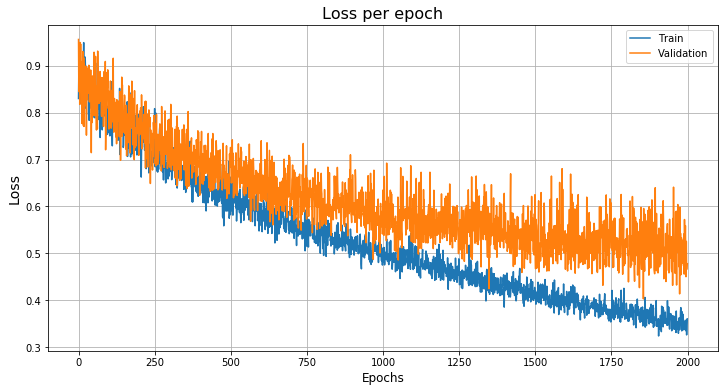

Accuracy_Score is 0.869198312236287
Precision_Score is 0.3
ROC_AUC_Score is 0.688676967648479
recall_score is 0.47368421052631576
f1_score is 0.3673469387755102
Confusion_Matrix is 
 [[197  21]
 [ 10   9]]


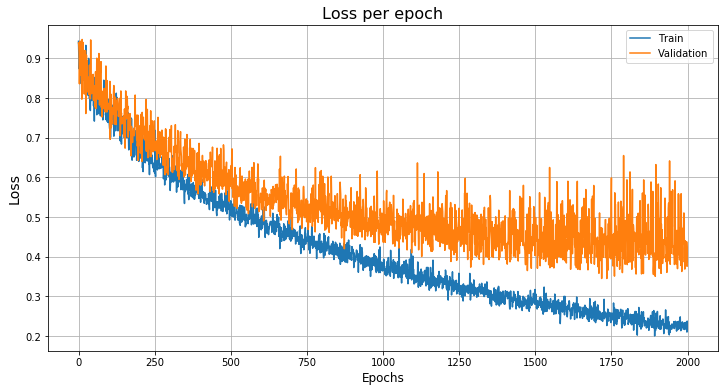

Accuracy_Score is 0.890295358649789
Precision_Score is 0.3157894736842105
ROC_AUC_Score is 0.6280782230806374
recall_score is 0.3157894736842105
f1_score is 0.3157894736842105
Confusion_Matrix is 
 [[205  13]
 [ 13   6]]


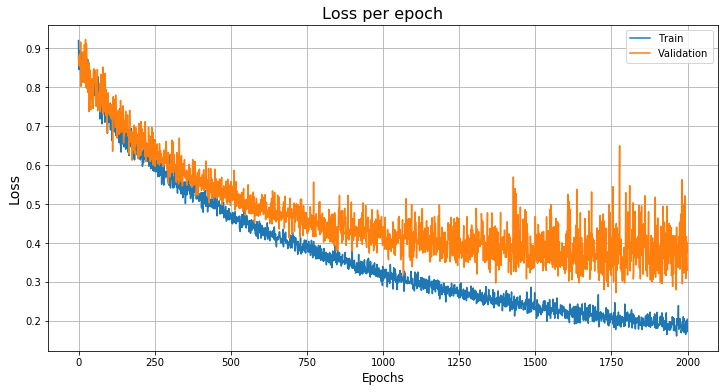

Accuracy_Score is 0.9156118143459916
Precision_Score is 0.4666666666666667
ROC_AUC_Score is 0.6658619024625785
recall_score is 0.3684210526315789
f1_score is 0.4117647058823529
Confusion_Matrix is 
 [[210   8]
 [ 12   7]]


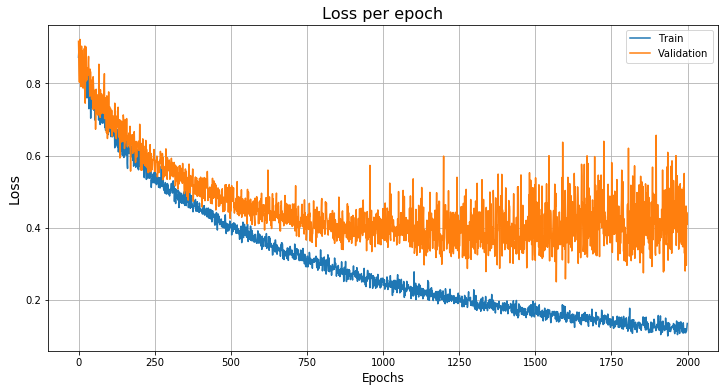

Accuracy_Score is 0.8860759493670886
Precision_Score is 0.25
ROC_AUC_Score is 0.5777402221149203
recall_score is 0.21052631578947367
f1_score is 0.22857142857142856
Confusion_Matrix is 
 [[206  12]
 [ 15   4]]


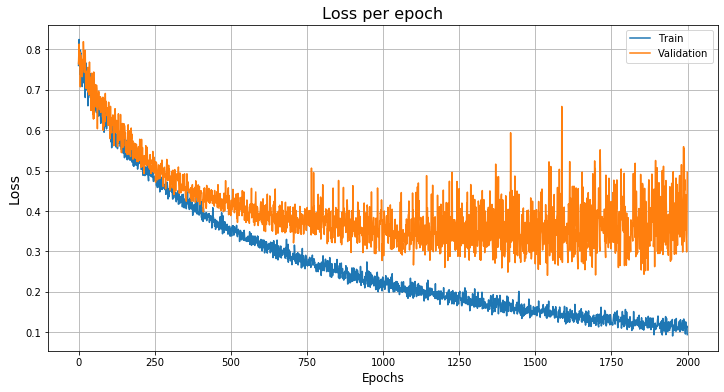

Accuracy_Score is 0.9071729957805907
Precision_Score is 0.38461538461538464
ROC_AUC_Score is 0.61323032351521
recall_score is 0.2631578947368421
f1_score is 0.3125
Confusion_Matrix is 
 [[210   8]
 [ 14   5]]


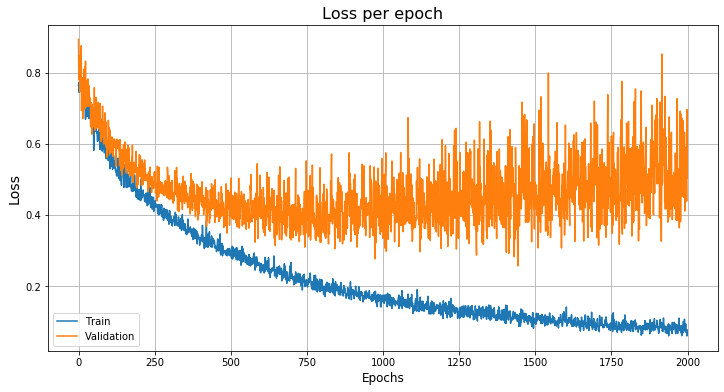

Accuracy_Score is 0.8945147679324894
Precision_Score is 0.36363636363636365
ROC_AUC_Score is 0.6784162240463544
recall_score is 0.42105263157894735
f1_score is 0.3902439024390244
Confusion_Matrix is 
 [[204  14]
 [ 11   8]]


In [16]:
epochs = 2000
momentum = 1e-3
lr_list = [0.001,0.002, 0.003, 0.004, 0.005, 0.006]

acc_list = []
roc_list = []
recall_list =[]
f1_list = []
confusion_m_list = []
y_pred_list = []
checkpoint_list = ['checkpoint_1.pth', 'checkpoint_2.pth', 'checkpoint_3.pth', 'checkpoint_4.pth', 'checkpoint_5.pth', 'checkpoint_6.pth']

for lr_idx in range(len(lr_list)):
    
    acc,pre, roc, recall, f1, confusion_m, y_pred, model_saved = run_model(lr_list[lr_idx],momentum, epochs, train_A_tensor, train_A_label_tensor, val_data_tensor, val_label_tensor, checkpoint_list[lr_idx])
    acc_list.append(acc)
    roc_list.append(pre)
    recall_list.append(recall)
    f1_list.append(f1)
    confusion_m_list.append(confusion_m)
    y_pred_list.append(y_pred)


### Section 2-2 : Pseudo-Labeling 
* To be assigned predicted labels (pseudo-labels) by a selected trained model
* The newly appointed labels will act as true labels


In [18]:
##  Pseudo_Labeling ###

# In this section, the dataset, X_train_B, will be assiend predicted labels by the trained network.
model_reload = load_checkpoint('checkpoint_3.pth')
y_pred_B = model_reload.forward(train_B_tensor)
pseudo_label_train_B = model_reload.predict(y_pred_B)
acc_pseudo, prec_score_pseudo, roc_score_pseudo, recall_score_pseudo, f1_score_pseudo, confusion_mat_pseudo = evaluation_metrics(pseudo_label_train_B, train_B_label_tensor)

Accuracy_Score is 0.8964059196617337
Precision_Score is 0.1875
ROC_AUC_Score is 0.5234845799361928
recall_score is 0.07692307692307693
f1_score is 0.1090909090909091
Confusion_Matrix is 
 [[421  13]
 [ 36   3]]


## Section 3 : Train the FNN Model with a combined dataset & predicted binary labels

### Section 3-1 : Train the FNN model with a combined dataset
* Combined the halved datasets into one dataset 
* Pseudo_labels of the train_B dataset will be used as true labels 
* Train the defined model with a list of different learning rate values 
* epochs and momentum remain same as the previous settings

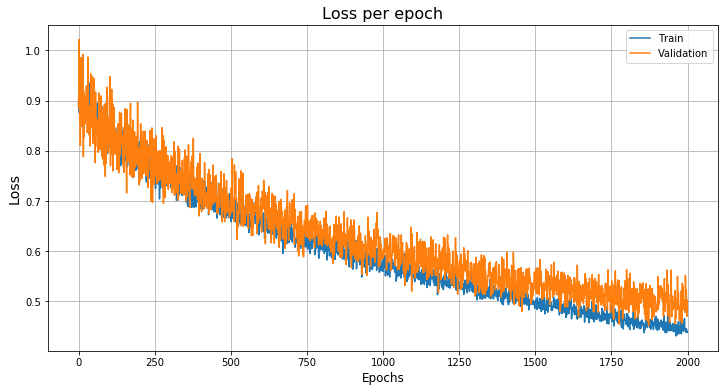

Accuracy_Score is 0.8481012658227848
Precision_Score is 0.13043478260869565
ROC_AUC_Score is 0.5330758087880251
recall_score is 0.15789473684210525
f1_score is 0.14285714285714288
Confusion_Matrix is 
 [[198  20]
 [ 16   3]]


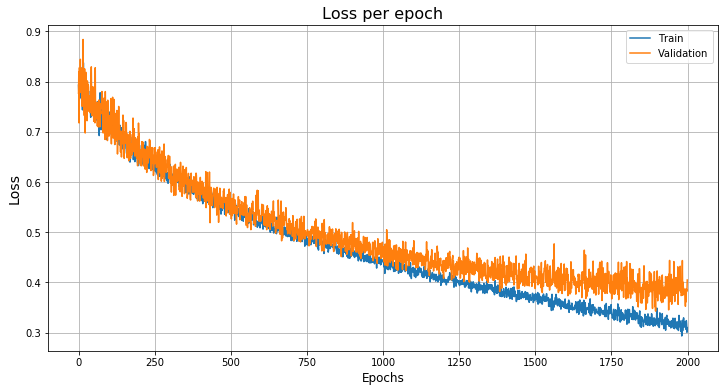

Accuracy_Score is 0.9156118143459916
Precision_Score is 0.45454545454545453
ROC_AUC_Score is 0.6178174794785127
recall_score is 0.2631578947368421
f1_score is 0.3333333333333333
Confusion_Matrix is 
 [[212   6]
 [ 14   5]]


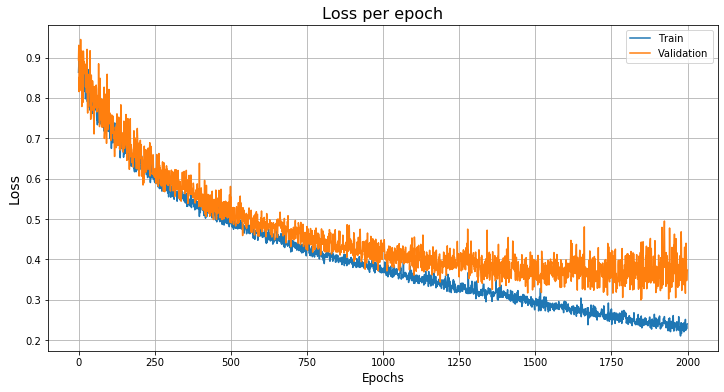

Accuracy_Score is 0.8945147679324894
Precision_Score is 0.2857142857142857
ROC_AUC_Score is 0.5823273780782231
recall_score is 0.21052631578947367
f1_score is 0.24242424242424243
Confusion_Matrix is 
 [[208  10]
 [ 15   4]]


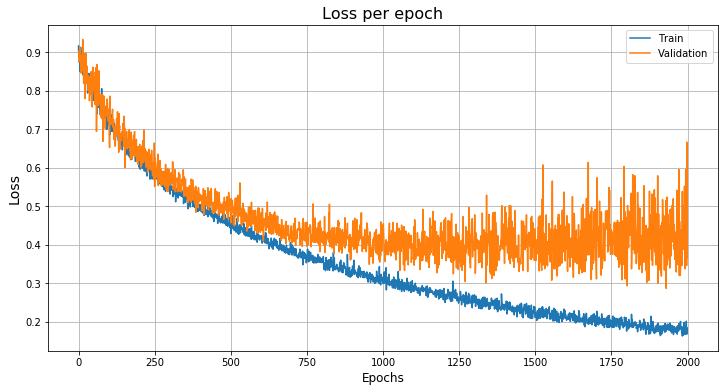

Accuracy_Score is 0.890295358649789
Precision_Score is 0.29411764705882354
ROC_AUC_Score is 0.6040560115886044
recall_score is 0.2631578947368421
f1_score is 0.27777777777777773
Confusion_Matrix is 
 [[206  12]
 [ 14   5]]


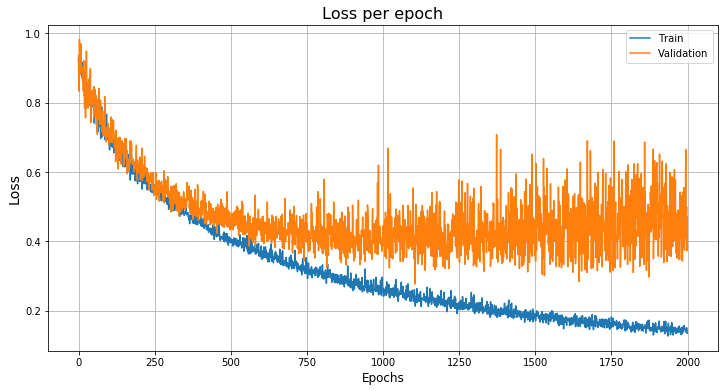

Accuracy_Score is 0.8987341772151899
Precision_Score is 0.3333333333333333
ROC_AUC_Score is 0.6086431675519073
recall_score is 0.2631578947368421
f1_score is 0.29411764705882354
Confusion_Matrix is 
 [[208  10]
 [ 14   5]]


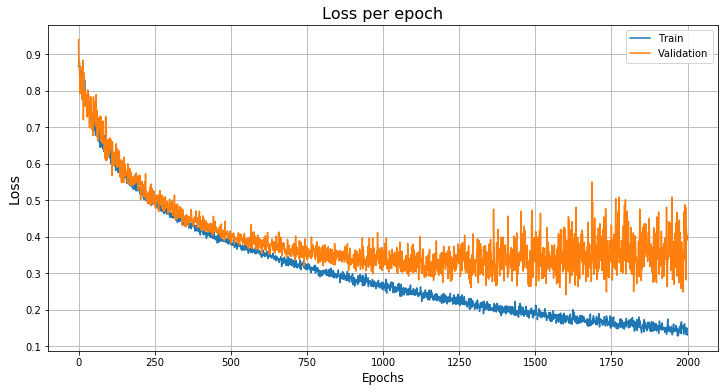

Accuracy_Score is 0.8818565400843882
Precision_Score is 0.09090909090909091
ROC_AUC_Score is 0.5033800096571704
recall_score is 0.05263157894736842
f1_score is 0.06666666666666667
Confusion_Matrix is 
 [[208  10]
 [ 18   1]]


In [20]:
# To combine the halved datasets into a dataset with corresponding true labels (train_A) and pseudo-labels (train_B)
train_AB_tensor, train_AB_label_tensor = preparation_train_data_AB(X_train_A, y_train_A, X_train_B, pseudo_label_train_B)

# train the defined Forward Neural Network with the combined dataset (train_AB_tensor and its corresponding labels)
acc_list_AB = []
roc_list_AB = []
recall_list_AB =[]
f1_list_AB = []
confusion_m_list_AB = []
y_pred_list_AB = []
checkpoint_list_AB = ['checkpoint_1_AB.pth', 'checkpoint_2_AB.pth', 'checkpoint_3_AB.pth', 'checkpoint_4_AB.pth', 'checkpoint_5_AB.pth', 'checkpoint_6_AB.pth']

for lr_idx in range(len(lr_list)):
    
    acc_AB,pre_AB, roc_AB, recall_AB, f1_AB, confusion_m_AB, y_pred_AB, model_saved_AB = run_model(lr_list[lr_idx],momentum, epochs, train_AB_tensor, train_AB_label_tensor, val_data_tensor, val_label_tensor, checkpoint_list_AB[lr_idx])
    acc_list_AB.append(acc_AB)
    roc_list_AB.append(pre_AB)
    recall_list_AB.append(recall_AB)
    f1_list_AB.append(f1_AB)
    confusion_m_list_AB.append(confusion_m_AB)
    y_pred_list_AB.append(y_pred_AB)

### Section 3-2 : Assign new pseudo-labels of "train_B_tensor"

In [21]:
## To be continued to run the provided test dataset!
model_reload_AB = load_checkpoint('checkpoint_2_AB.pth')
train_B_pred_probability = model_reload_AB.forward(train_B_tensor)
train_B_pseudo_labels = model_reload_AB.predict(train_B_pred_probability)

acc_pseudo_AB, prec_score_pseudo_AB, roc_score_pseudo_AB, recall_score_pseudo_AB, f1_score_pseudo_AB, confusion_mat_pseudo_AB = evaluation_metrics(train_B_pseudo_labels, train_B_label_tensor)

Accuracy_Score is 0.9534883720930233
Precision_Score is 1.0
ROC_AUC_Score is 0.717948717948718
recall_score is 0.4358974358974359
f1_score is 0.6071428571428571
Confusion_Matrix is 
 [[434   0]
 [ 22  17]]
